# K-means Clustering

K Means is an algorithm to determine clusters for data, which is motivated by the idea that the distance between a point and the points in its assigned cluster should be small compared to the distance between a point and those that are not in its cluster. That is, the inter-point distances should be small compared to the intra-point distances. All that remains is to mathematically represent this.

Suppose we have a set of data points $\textbf{x} = (\textbf{x}_{1}, ... , \textbf{x}_{N})$ which are $D$ dimensional. We can represent the centers of our clusters with $\mu_{k}$ for $k = 1, ... , K$. For now we can assume $K$ is given to us, as deciding on a $K$ is another problem involving cross-validation.

To represent the assignment of $\textbf{x}_{n}$ to a cluster $k$, we can use indicator variables $r_{nk}$ such that 
$$r_{nk} = \begin{cases}
                1 & \text{if } \textbf{x}_{n} \in \text{cluster k} \\
                0 & \text{o.w.}
           \end{cases}$$
                
Finally, we can describe the error of our assignment using the squared distances between points and their assigned cluster center $\mu_{k}$, which can be summed up in the function 
$$ J = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk} \|\textbf{x}_{n} - \mu_{k}\|^2$$

We now have all the pieces to formulate the algorithm. Note that our error function $J$ cannot simply be differentiated with respect to $\mu_{k}$ and $r_{nk}$ because the latter is discrete. Instead, we need to iteratively update $J$ using the following steps.

1. Initialize $\mu_{k}$. The method we will be using is to just sample $K$ of our data points. 


2. For each n there can only be one $r_{nk}$ that equals $1$. So we assign $k = \underset{j}{\arg\max} \|\textbf{x}_{n} - \mu_{j}\|^2$, which assigns the point $x_{n}$ to the cluster whose center is closest to it.


3. Fixing $r_{nk}$, we can now differentiate $J$ with respect to $\mu_{k}$ and set equal to $0$, which yields
$$ -2 \sum_{n=1}^{N} r_{nk} ( \textbf{x}_{n} - \mu_{k} ) = 0$$

$$\implies\mu_{k} = \frac{\sum_{n=1}^{N} r_{nk} x_{n}}{\sum_{n=1}^{N} r_{nk}}$$

Intuitively, this updates each center to be the mean of the points assigned to it (and is the namesake of the algorithm).

4. If the centers don't change after step 3, terminate. Otherwise repeat steps 2 and 3.

This algorithm is pretty straightforward logically. We will now implement it.

In [134]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [210]:
def kmeans(data, k):
    # step 1
    centers = data[np.random.randint(data.shape[0], size=k), :]
    newcenters = np.zeros(centers.shape)
    abort = 0
    while(True):
        # step 2
        temp = np.empty([len(centers), len(data)])
        for i in np.arange(len(centers)):
            temp[i] = np.linalg.norm(data - centers[i], axis=1)
        dist = pd.DataFrame(temp.T)
        rnk = np.array(dist.idxmin(axis=1))
        
        if(abort):
            return(newcenters, rnk)
        
        # step 3
        for i in np.arange(len(centers)):
            newcenters[i] = np.sum(data[np.where(rnk==i)[0], :], axis=0) / len(np.where(rnk==i)[0])
        #print(newcenters)
        
        if(np.array_equal(centers, newcenters)):
            abort = 1
        else:
            centers = newcenters

Here we initialize the centers by sampling $K$ data points as described above. To compare the updated centers with the old ones, we will assign the new ones to a separate variable. 

Since we require the algorithm to run at least once, we implement a do-while loop. Within this loop we start with step 2, where we calculate the distances between the data points and each center, storing each as a column in a dataframe. We then extract the index of the minimum of each row, which effectively assigns each data point to a cluster from $0$ to $K-1$. 

Moving on to step 3, we update the centers by assigning them to the mean of the points in the corresponding clusters. If these new centers are the same as the old ones, we signal the loop to terminate. However, before terminating we need to update the labels one more time, and so the breakpoint needs to be placed between step 2 and step 3.

In [212]:
c1numpoints = 10
c2numpoints = 10
c3numpoints = 10

mu1 = np.array([1, 2])
sigma1 = np.array([[1, 0.5], [0.5, 1]])
c1 = np.random.multivariate_normal(mu1, sigma1, c1numpoints)

mu2 = np.array([1, -2])
sigma2 = np.array([[1, 0.5], [0.5, 1]])
c2 = np.random.multivariate_normal(mu2, sigma2, c2numpoints)

mu3 = np.array([5, -2])
sigma3 = np.array([[1, 0.5], [0.5, 1]])
c3 = np.random.multivariate_normal(mu3, sigma3, c3numpoints)

x = np.vstack((c1, c2, c3))
#plt.plot(c1[:, 0], c1[:, 1], 'bo')
#plt.plot(c2[:, 0], c2[:, 1], 'rx')
#plt.plot(c3[:, 0], c3[:, 1], 'g+')

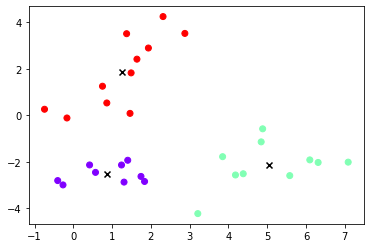

In [217]:
convcenter, labels = kmeans(x, 3)
plt.scatter(x[:, 0], x[:, 1], c=labels, cmap='rainbow')
plt.scatter(convcenter[:, 0], convcenter[:, 1], marker='x', color='black')
#plt.plot(x[np.where(labels == 0)[0], 0], x[np.where(labels == 0)[0], 1], 'bo')
#plt.plot(x[np.where(labels == 1)[0], 0], x[np.where(labels == 1)[0], 1], 'ro')
#plt.plot(x[np.where(labels == 2)[0], 0], x[np.where(labels == 2)[0], 1], 'go')
#plt.plot(convcenter[0, 0], convcenter[0, 1], 'kx')
#plt.plot(convcenter[1, 0], convcenter[1, 1], 'kx')
#plt.plot(convcenter[2, 0], convcenter[2, 1], 'kx')

If you run this algorithm multiple times you might notice that sometimes the algorithm fails to finish running. This could be because of bad initializations for our means. 

Another issue is that sometimes the algorithm converges, but the resulting centers and labels seem nonsensical. This is due to the fact that K-means locally converges but does not always globally converge due to being a nonparametric method. We can overcome this by running the algorithm multiple times and selecting the centers and labels from the model with the smallest error.  